In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from LQN_utils_state_save_parallel import *
import itertools
from copy import deepcopy
import sympy as sp
from itertools import groupby

In [15]:
import networkx as nx
import pynauty as nauty
import hashlib
import itertools

# NetworkX 그래프 -> pynauty 그래프로 변환
def to_nauty_graph(nx_graph):
    nx_graph = nx.convert_node_labels_to_integers(nx_graph)  # 정수형 노드로 변환
    n = nx_graph.number_of_nodes()
    g = nauty.Graph(number_of_vertices=n, directed=False)
    for u, v in nx_graph.edges():
        g.connect_vertex(u, v)
    return g

# Canonical Form 해시 생성
def canonical_hash(nx_graph):
    try:
        g = to_nauty_graph(nx_graph)
        cert = nauty.certificate(g)  # Canonical Form 생성
        return hashlib.md5(cert).hexdigest()  # 해시값 반환
    except Exception as e:
        print(f"Error in canonical_hash: {e}")
        return None

In [16]:
# EPM Bipartite Graph Generator
def EPM_bipartite_graph_generator(num_system, num_ancilla, type): 
    results = []  # 결과를 저장할 리스트
    canonical_forms_seen = set()  # 중복된 Canonical Form을 저장하기 위한 set
    num_total = num_system + num_ancilla

    # Red-Blue 조합 생성
    if type == 0:
        red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # Ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    # Red-Blue와 Ancilla 조합을 기반으로 그래프 생성
    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # Red-Blue 조합 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = rb_index

                # Ancilla 조합 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3)

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                # 노드 속성 설정
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)

                # 이웃 수 조건 확인
                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    canonical_form = canonical_hash(B)

                    # 중복 확인
                    if canonical_form and canonical_form not in canonical_forms_seen:
                        canonical_forms_seen.add(canonical_form)
                        results.append((B, canonical_form))

        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            # Red-Blue 조합 추가
            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            # 노드 속성 설정
            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            # 이웃 수 조건 확인
            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                canonical_form = canonical_hash(B)

                # 중복 확인
                if canonical_form and canonical_form not in canonical_forms_seen:
                    canonical_forms_seen.add(canonical_form)
                    results.append((B, canonical_form))

    return results  # 최종 결과 반환


In [17]:
bi_result_3_1 = EPM_bipartite_graph_generator(3, 1, 0)

In [6]:
len(bi_result_3_1)

8

In [7]:
bi_result_3_1[0]

(<networkx.classes.graph.Graph at 0x7f37e37d9120>,
 '87e07f47d39141dcd1b8141fcbed9e41')

In [8]:
bi_result_3_1[0][0]

In [9]:
bi_result_3_1[0][1]

'87e07f47d39141dcd1b8141fcbed9e41'

In [10]:
bi_result_3_1[1][1]

'c6de2a6d3c934078d5e619060f2122d6'

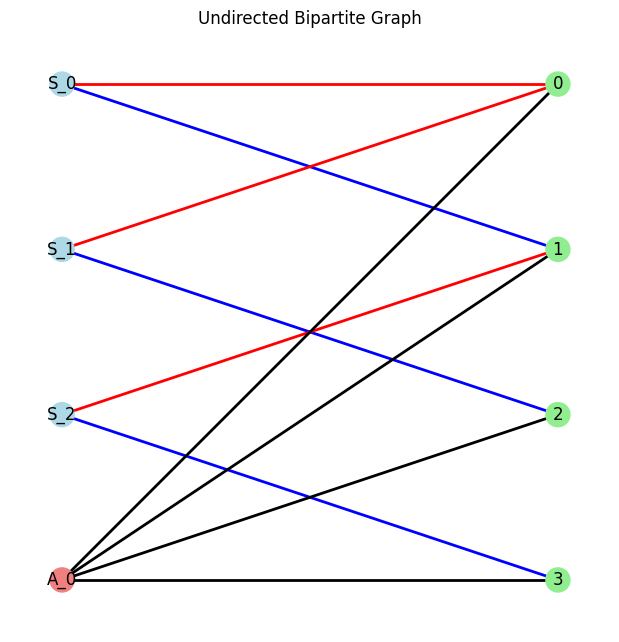

In [11]:
Draw_EPM_bipartite_graph(bi_result_3_1[7][0])

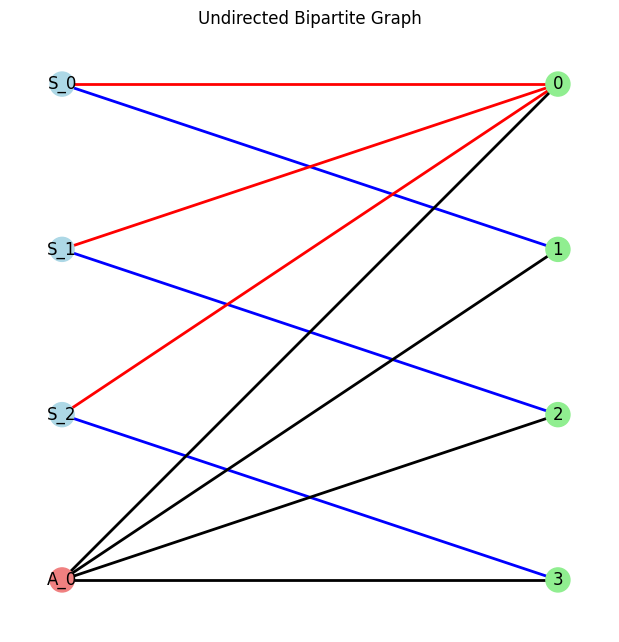

In [12]:
Draw_EPM_bipartite_graph(bi_result_3_1[4][0])

In [13]:
import networkx as nx

# 두 개의 동형 그래프 생성
graph1 = nx.complete_bipartite_graph(3, 2)
graph2 = nx.complete_bipartite_graph(2, 3)

# Canonical Hash 계산
hash1 = canonical_hash(graph1)
hash2 = canonical_hash(graph2)

print(f"Hash1: {hash1}")
print(f"Hash2: {hash2}")
print(f"Are the graphs isomorphic? {hash1 == hash2}")


Hash1: 3d2911e526d9d9fde3fdddd1a612f9e2
Hash2: 3d2911e526d9d9fde3fdddd1a612f9e2
Are the graphs isomorphic? True


In [14]:
# 비동형 그래프 생성
graph3 = nx.cycle_graph(5)

# Canonical Hash 계산
hash3 = canonical_hash(graph3)

print(f"Hash1: {hash1}")
print(f"Hash3: {hash3}")
print(f"Are the graphs isomorphic? {hash1 == hash3}")

Hash1: 3d2911e526d9d9fde3fdddd1a612f9e2
Hash3: ac8adb5e4123cb838227a9c27e38ab07
Are the graphs isomorphic? False


In [15]:
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과를 저장할 리스트
    num_total = num_system + num_ancilla

    if type == 0:
        red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight= 1.0)
                    B.add_edge(rb_index, blue, weight= 2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)  # mapping은 그래프 index임(bigraph에서 왼쪽)
                    mapping[num_total + rb_index] = rb_index  # bigraph에서 오른쪽 vertex


                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # B의 index를 mapping에서 우리가 만든 형태로 다 바꿈.

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append((B))
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.)
                B.add_edge(rb_index, blue, weight= 2.)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append((B))

    return results  # 최종 결과 반환

In [16]:
bi_result_old_3_1 = EPM_bipartite_graph_generator_old(3, 1, 0)

In [17]:
bi_result_old_3_1[0]

In [18]:
len(bi_result_old_3_1)

3264

In [19]:
canonical_hash(bi_result_old_3_1[0])

'87e07f47d39141dcd1b8141fcbed9e41'

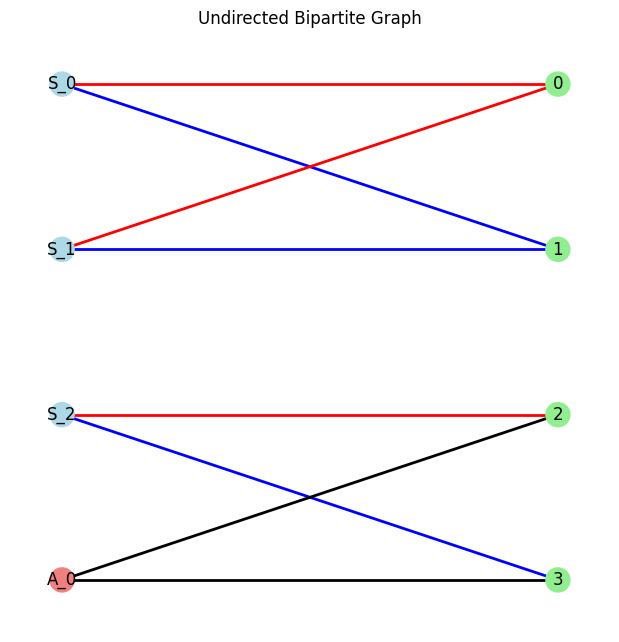

In [20]:
Draw_EPM_bipartite_graph(bi_result_old_3_1[0])

In [21]:
canonical_hash(bi_result_old_3_1[4])

'87e07f47d39141dcd1b8141fcbed9e41'

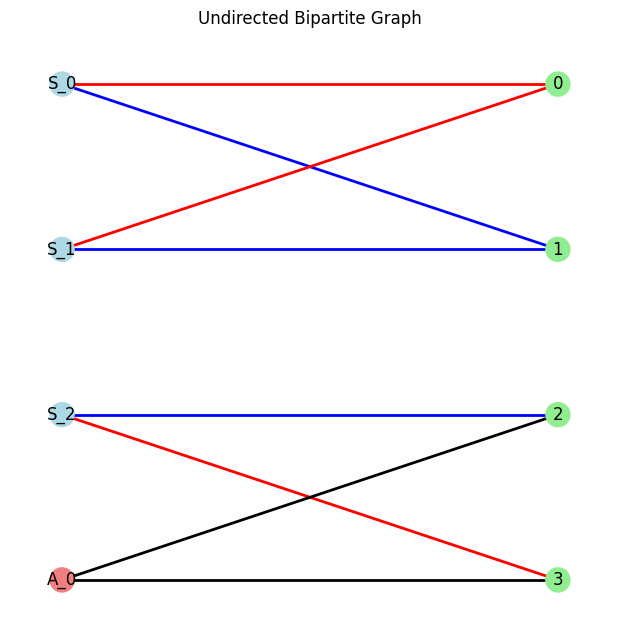

In [22]:
Draw_EPM_bipartite_graph(bi_result_old_3_1[4])

In [23]:
import networkx as nx
import pynauty as nauty
import hashlib
import itertools
from collections import defaultdict

# NetworkX 그래프 -> pynauty 그래프로 변환
def to_nauty_graph(nx_graph):
    nx_graph = nx.convert_node_labels_to_integers(nx_graph)  # 정수형 노드로 변환
    n = nx_graph.number_of_nodes()
    g = nauty.Graph(number_of_vertices=n, directed=False)
    for u, v in nx_graph.edges():
        g.connect_vertex(u, v)
    return g

# Canonical Form 해시 생성
def canonical_hash(nx_graph):
    try:
        g = to_nauty_graph(nx_graph)
        cert = nauty.certificate(g)  # Canonical Form 생성
        return hashlib.md5(cert).hexdigest()  # 해시값 반환
    except Exception as e:
        print(f"Error in canonical_hash: {e}")
        return None

# EPM Bipartite Graph Generator
def EPM_bipartite_graph_generator_test(num_system, num_ancilla, type): 
    results = defaultdict(list)  # Canonical Hash별로 그래프를 그룹화
    num_total = num_system + num_ancilla

    # Red-Blue 조합 생성
    if type == 0:
        red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # Ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    # Red-Blue와 Ancilla 조합을 기반으로 그래프 생성
    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # Red-Blue 조합 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = rb_index

                # Ancilla 조합 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3)

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                # 노드 속성 설정
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)

                # 이웃 수 조건 확인
                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    canonical_form = canonical_hash(B)

                    # 그룹화
                    if canonical_form:
                        results[canonical_form].append(B)

        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            # Red-Blue 조합 추가
            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            # 노드 속성 설정
            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            # 이웃 수 조건 확인
            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                canonical_form = canonical_hash(B)

                # 그룹화
                if canonical_form:
                    results[canonical_form].append(B)

    return results  # Canonical Hash별로 그룹화된 결과 반환


In [24]:
bi_result_test_3_1 = EPM_bipartite_graph_generator_test(3, 1, 0)

In [48]:
len(bi_result_test_3_1)

8

In [25]:
list(bi_result_test_3_1.keys())[0]

'87e07f47d39141dcd1b8141fcbed9e41'

In [26]:
bi_result_test_3_1[list(bi_result_test_3_1.keys())[0]][0]

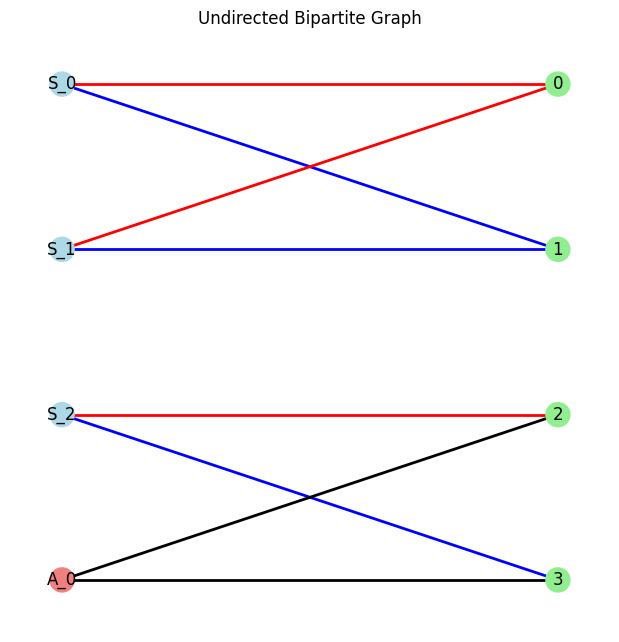

In [27]:
Draw_EPM_bipartite_graph(bi_result_test_3_1[list(bi_result_test_3_1.keys())[0]][0])

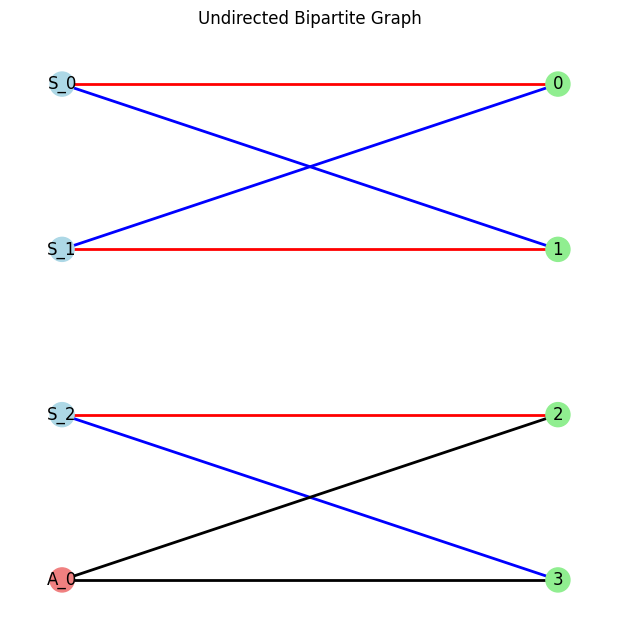

In [28]:
Draw_EPM_bipartite_graph(bi_result_test_3_1[list(bi_result_test_3_1.keys())[0]][2])

In [29]:
bi_result_test_3_1[list(bi_result_test_3_1.keys())[0]][0]

In [ ]:
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과를 저장할 리스트
    num_total = num_system + num_ancilla

    if type == 0:
        red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight= 1.0)
                    B.add_edge(rb_index, blue, weight= 2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)  # mapping은 그래프 index임(bigraph에서 왼쪽)
                    mapping[num_total + rb_index] = rb_index  # bigraph에서 오른쪽 vertex


                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # B의 index를 mapping에서 우리가 만든 형태로 다 바꿈.

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append((B))
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.)
                B.add_edge(rb_index, blue, weight= 2.)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append((B))

    return results  # 최종 결과 반환

In [38]:
import igraph as ig

# NetworkX -> igraph 변환
def to_igraph(nx_graph):
    edges = list(nx_graph.edges)
    g = ig.Graph(edges=edges, directed=False)
    return g

# Canonical form 비교
def canonical_form(graph):
    return graph.canonical_permutation()

# Example bipartite graph list
bigraphs = [
    nx.Graph([(0, 3), (1, 3), (2, 4)]),
    nx.Graph([(0, 3), (1, 3), (2, 4)]),
    nx.Graph([(0, 4), (1, 4), (2, 5)])
]

# Canonical form 계산
canonical_forms = []
for i, graph in enumerate(bigraphs):
    igraph = to_igraph(graph)
    canonical_forms.append(canonical_form(igraph))

# 결과 비교
for i in range(len(canonical_forms)):
    for j in range(i + 1, len(canonical_forms)):
        if canonical_forms[i] == canonical_forms[j]:
            print(f"Graph {i+1} and Graph {j+1} are isomorphic.")
        else:
            print(f"Graph {i+1} and Graph {j+1} are NOT isomorphic.")



Graph 1 and Graph 2 are isomorphic.
Graph 1 and Graph 3 are NOT isomorphic.
Graph 2 and Graph 3 are NOT isomorphic.


In [39]:
canonical_forms

[[3, 2, 1, 4, 0], [3, 2, 1, 4, 0], [4, 3, 2, 0, 5, 1]]

In [40]:
import igraph as ig

# Canonical Form 생성 함수
def canonical_form_with_weights(graph, weights):
    # 노드 가중치를 색상(label)으로 추가
    graph.vs['weight'] = weights  # 노드 속성 설정
    # 색상(label)을 고려한 canonical permutation 계산
    perm = graph.canonical_permutation(color=graph.vs['weight'])
    # Permutation 적용하여 정렬된 adjacency matrix 반환
    permuted = graph.permute_vertices(perm)
    return permuted.get_adjacency().data

# Canonical form with weights
def canonical_form_with_weights(ig_graph):
    # 가중치를 색상(label)으로 설정
    ig_graph.vs['color'] = [v['weight'] for v in ig_graph.es]
    # Canonical permutation 생성
    perm = ig_graph.canonical_permutation(color=ig_graph.vs['color'])
    # Permutation 적용
    permuted = ig_graph.permute_vertices(perm)
    return permuted.get_adjacency().data


# 그래프 정의 및 가중치 설정
g1 = ig.Graph([(0, 1), (1, 2)])
g2 = ig.Graph([(0, 1), (1, 2)])
g3 = ig.Graph([(0, 1), (1, 2)])

weights1 = [2, 3, 4]  # Graph 1 가중치
weights2 = [2, 3, 4]  # Graph 2 가중치 (동형)
weights3 = [2, 4, 3]  # Graph 3 가중치 (비동형)

# Canonical form 계산
matrix1 = canonical_form_with_weights(g1, weights1)
matrix2 = canonical_form_with_weights(g2, weights2)
matrix3 = canonical_form_with_weights(g3, weights3)

# Canonical form 비교
print(matrix1 == matrix2)  # True (동형)
print(matrix1 == matrix3)  # False (비동형)


True
False


In [41]:
matrix1

[[0, 1, 0], [1, 0, 1], [0, 1, 0]]

In [46]:
import networkx as nx
import igraph as ig

# 1. NetworkX에서 bipartite graph 생성
G = nx.Graph()
G.add_nodes_from([0, 1, 2], bipartite=0)  # 그룹 1
G.add_nodes_from([3, 4], bipartite=1)    # 그룹 2
G.add_edges_from([(0, 3, {'weight': 1}), (1, 3, {'weight': 2}), (2, 4, {'weight': 3})])

# 2. NetworkX → iGraph 변환
def nx_to_igraph(nx_graph):
    # 노드 및 엣지 정보 추출
    edges = list(nx_graph.edges(data=True))
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(nx_graph.nodes))  # 노드 추가
    ig_graph.add_edges([(u, v) for u, v, _ in edges])  # 엣지 추가
    
    # 가중치 추가
    weights = [data['weight'] for _, _, data in edges]
    ig_graph.es['weight'] = weights
    
    return ig_graph

# 3. 변환 테스트
ig_graph = nx_to_igraph(G)
print(ig_graph)  # iGraph 출력



IGRAPH U-W- 5 3 --
+ attr: weight (e)
+ edges:
0--3 1--3 2--4


In [47]:
# Canonical form with weights
def canonical_form_with_weights(ig_graph):
    # 가중치를 색상(label)으로 설정
    ig_graph.vs['color'] = [v['weight'] for v in ig_graph.es]
    # Canonical permutation 생성
    perm = ig_graph.canonical_permutation(color=ig_graph.vs['color'])
    # Permutation 적용
    permuted = ig_graph.permute_vertices(perm)
    return permuted.get_adjacency().data

# Canonical form 계산
canonical_matrix = canonical_form_with_weights(ig_graph)
print(canonical_matrix)

[[0, 1, 0, 0, 0], [1, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 0]]


In [54]:
import networkx as nx
import igraph as ig
import itertools


# EPM bipartite graph 생성 함수
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과 저장 리스트
    num_total = num_system + num_ancilla

    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = rb_index

                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                # 노드 속성 추가
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # 노드 이름 변경

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append(B)
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append(B)

    return results  # 최종 결과 반환


# NetworkX -> iGraph 변환
def nx_to_igraph(nx_graph):
    # 노드 매핑 (문자열 → 정수 변환)
    node_map = {node: idx for idx, node in enumerate(nx_graph.nodes)}

    # 엣지 및 가중치 추출
    edges = []
    weights = []
    for u, v, data in nx_graph.edges(data=True):
        edges.append((node_map[u], node_map[v]))  # 정수 인덱스로 변환된 엣지 추가
        weights.append(data['weight'])  # 가중치 추가

    # iGraph 객체 생성
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(node_map))  # 노드 추가
    ig_graph.add_edges(edges)  # 엣지 추가
    ig_graph.es['weight'] = weights  # 가중치 추가
    return ig_graph


# Canonical Form 생성
def canonical_form_with_weights(ig_graph):
    ig_graph.vs['color'] = [v['weight'] for v in ig_graph.es]  # 색상(label) 설정
    perm = ig_graph.canonical_permutation(color=ig_graph.vs['color'])  # canonical permutation
    permuted = ig_graph.permute_vertices(perm)  # 정렬 적용
    return tuple(map(tuple, permuted.get_adjacency().data))  # Immutable 변환


# 그래프 리스트 처리 및 중복 제거
def process_and_deduplicate(graph_list):
    canonical_set = set()  # 중복 제거를 위한 set
    for graph in graph_list:
        ig_graph = nx_to_igraph(graph)  # NetworkX → iGraph 변환
        canonical_form = canonical_form_with_weights(ig_graph)  # Canonical Form 생성
        canonical_set.add(canonical_form)  # 중복 제거
    return canonical_set

Original graph count: 3264
Unique graph count: 106


In [56]:
# EPM bipartite graph 생성
graph_list = EPM_bipartite_graph_generator_old(num_system=3, num_ancilla=1, type=0)

# 중복 제거된 canonical forms 추출
unique_graphs = process_and_deduplicate(graph_list)

# 결과 출력
print(f"Original graph count: {len(graph_list)}")
print(f"Unique graph count: {len(unique_graphs)}")


Original graph count: 3264
Unique graph count: 106


In [69]:
import igraph as ig

# 그래프 정의
G1 = ig.Graph([(0, 1), (1, 2), (2, 0), (2, 3)])   # 그래프 1
G2 = ig.Graph([(0, 1), (1, 2)])  # 그래프 2

# Canonical Form 생성 함수
def canonical_form(graph):
    # Canonical permutation 계산
    perm = graph.canonical_permutation()
    # Permutation 적용
    permuted = graph.permute_vertices(perm)
    # Adjacency matrix 반환
    return tuple(map(tuple, permuted.get_adjacency().data))

# Canonical Form 비교
print(canonical_form(G1) == canonical_form(G2))  # True


False


In [70]:
perm = G1.canonical_permutation()
perm

[2, 1, 3, 0]

In [71]:
permuted = G1.permute_vertices(perm)
print(permuted)

IGRAPH U--- 4 4 --
+ edges:
1--2 1--3 2--3 0--3


In [72]:
print(permuted.get_adjacency().data)

[[0, 0, 0, 1], [0, 0, 1, 1], [0, 1, 0, 1], [1, 1, 1, 0]]


In [76]:
import networkx as nx
from networkx.algorithms.isomorphism import GraphMatcher

# 예제 가중치 이분 그래프
G = nx.Graph()
G.add_nodes_from([1, 2], bipartite=0)  # 첫 번째 파트
G.add_nodes_from([3, 4], bipartite=1)  # 두 번째 파트
G.add_edges_from([(1, 3, {'weight': 2}), (2, 4, {'weight': 3})])  # 가중치 추가

# 정규 라벨링 함수
def canonical_labeling(graph):
    # 가중치 정보 반영
    relabeled_graph = nx.Graph()
    for u, v, data in graph.edges(data=True):
        relabeled_graph.add_edge(min(u, v), max(u, v), label=data['weight'])
    # 사전식 정렬 수행
    edges = sorted((u, v, data['label']) for u, v, data in relabeled_graph.edges(data=True))
    return edges

# Canonical form 계산
canonical_label = canonical_labeling(G)

# 결과 출력
print("Canonical Labeling:")
print(canonical_label)



Canonical Labeling:
[(1, 3, 2), (2, 4, 3)]


In [74]:
import networkx as nx

# 예제 가중치 이분 그래프
G = nx.Graph()
G.add_nodes_from([1, 2], bipartite=0)  # 첫 번째 파트
G.add_nodes_from([3, 4], bipartite=1)  # 두 번째 파트
G.add_edges_from([(1, 3, {'weight': 2}), (2, 4, {'weight': 3})])  # 가중치 추가

# 튜플 변환 및 정규 라벨링
def canonical_labeling(graph):
    # 모든 간선 (u, v, w) 튜플 수집
    edge_list = [(min(u, v), max(u, v), data['weight']) for u, v, data in graph.edges(data=True)]
    # 사전식 정렬
    edge_list = sorted(edge_list)
    return edge_list

canonical_label = canonical_labeling(G)

# 결과 출력
print("Canonical Labeling:")
print(canonical_label)


Canonical Labeling:
[(1, 3, 2), (2, 4, 3)]


In [75]:
from grakel import Graph
from grakel.kernels import WeisfeilerLehman
import networkx as nx

# 예제 가중치 이분 그래프
G = nx.Graph()
G.add_nodes_from([1, 2], bipartite=0)  # 첫 번째 파트
G.add_nodes_from([3, 4], bipartite=1)  # 두 번째 파트
G.add_edges_from([(1, 3, {'weight': 2}), (2, 4, {'weight': 3})])  # 가중치 추가

# Grakel 그래프 변환
def to_grakel_format(graph):
    nodes = list(graph.nodes())
    edges = [(u, v) for u, v in graph.edges()]
    labels = {node: str(node) for node in nodes}  # 기본 라벨링
    return Graph(edges, node_labels=labels)

grakel_graph = to_grakel_format(G)

# WL 커널 적용
wl_kernel = WeisfeilerLehman(n_iter=2, normalize=True)
features = wl_kernel.fit_transform([grakel_graph, grakel_graph])

# 결과 출력
print("WL Features:")
print(features)


WL Features:
[[1. 1.]
 [1. 1.]]


In [77]:
import networkx as nx
from collections import defaultdict

# 그래프 리스트 생성
graphs = []

# 그래프 1
G1 = nx.Graph()
G1.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 1, {'weight': 3})])
graphs.append(G1)

# 그래프 2 (G1과 동형)
G2 = nx.Graph()
G2.add_edges_from([(10, 20, {'weight': 1}), (20, 30, {'weight': 2}), (30, 10, {'weight': 3})])
graphs.append(G2)

# 그래프 3 (G1과 비동형)
G3 = nx.Graph()
G3.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 3}), (3, 4, {'weight': 4})])
graphs.append(G3)

# 정규 라벨링 함수
def canonical_labeling(graph):
    # 간선 (u, v, weight) 튜플로 변환
    edge_list = [(min(u, v), max(u, v), data['weight']) for u, v, data in graph.edges(data=True)]
    # 사전식 정렬
    edge_list = sorted(edge_list)
    return tuple(edge_list)

# 정규화 수행
canonical_forms = []
for idx, graph in enumerate(graphs):
    canonical_form = canonical_labeling(graph)
    canonical_forms.append(canonical_form)
    print(f"Graph {idx+1} Canonical Form: {canonical_form}")

# Isomorphic Test 수행
def isomorphic_test(forms):
    n = len(forms)
    result = defaultdict(list)
    for i in range(n):
        for j in range(i + 1, n):
            if forms[i] == forms[j]:
                result[i + 1].append(j + 1)
    return result

# 결과 출력
iso_test = isomorphic_test(canonical_forms)
print("\nIsomorphic Pairs:")
for key, values in iso_test.items():
    print(f"Graph {key} is isomorphic with Graph {values}")


Graph 1 Canonical Form: ((1, 2, 1), (1, 3, 3), (2, 3, 2))
Graph 2 Canonical Form: ((10, 20, 1), (10, 30, 3), (20, 30, 2))
Graph 3 Canonical Form: ((1, 2, 1), (2, 3, 3), (3, 4, 4))

Isomorphic Pairs:


In [1]:
# 1. Nauty/Traces 기반 (NetworkX + 정렬 기반)
import networkx as nx
from networkx.algorithms.isomorphism import GraphMatcher
from collections import defaultdict

# 그래프 리스트 생성
graphs = []

# 그래프 1
G1 = nx.Graph()
G1.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 1, {'weight': 3})])
graphs.append(G1)

# 그래프 2 (G1과 동형)
G2 = nx.Graph()
G2.add_edges_from([(10, 20, {'weight': 1}), (20, 30, {'weight': 2}), (30, 10, {'weight': 3})])
graphs.append(G2)

# 그래프 3 (비동형)
G3 = nx.Graph()
G3.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 3}), (3, 4, {'weight': 4})])
graphs.append(G3)

# 정규 라벨링 (Nauty 방식)
def canonical_labeling_nauty(graph):
    # 가중치 포함 라벨링 처리
    relabeled_graph = nx.Graph()
    for u, v, data in graph.edges(data=True):
        relabeled_graph.add_edge(min(u, v), max(u, v), label=data['weight'])
    # 정규 라벨링: 사전식 정렬
    edges = sorted((u, v, data['label']) for u, v, data in relabeled_graph.edges(data=True))
    return tuple(edges)

canonical_forms_nauty = [canonical_labeling_nauty(g) for g in graphs]

# Isomorphic Test 수행
def isomorphic_test(forms):
    n = len(forms)
    result = defaultdict(list)
    for i in range(n):
        for j in range(i + 1, n):
            if forms[i] == forms[j]:
                result[i + 1].append(j + 1)
    return result

iso_test_nauty = isomorphic_test(canonical_forms_nauty)


# 2. 튜플 기반 사용자 정의 알고리즘
def canonical_labeling_tuple(graph):
    edge_list = [(min(u, v), max(u, v), data['weight']) for u, v, data in graph.edges(data=True)]
    edge_list = sorted(edge_list)  # 사전식 정렬
    return tuple(edge_list)

canonical_forms_tuple = [canonical_labeling_tuple(g) for g in graphs]
iso_test_tuple = isomorphic_test(canonical_forms_tuple)


# 3. WL(Wiesfeiler-Lehman) Refinement 기반
from grakel import Graph
from grakel.kernels import WeisfeilerLehman

# Grakel 형식 변환
def to_grakel_format(graph):
    nodes = list(graph.nodes())
    edges = [(u, v) for u, v in graph.edges()]
    labels = {node: str(node) for node in nodes}  # 기본 라벨링
    return Graph(edges, node_labels=labels)

grakel_graphs = [to_grakel_format(g) for g in graphs]

# WL 커널 적용
wl_kernel = WeisfeilerLehman(n_iter=2, normalize=True)
features = wl_kernel.fit_transform(grakel_graphs)

import pandas as pd

# 결과 정리 및 출력
results = {
    "Nauty Forms": canonical_forms_nauty,
    "Tuple Forms": canonical_forms_tuple,
    "WL Features": features.tolist(),
    "Nauty Iso Test": iso_test_nauty,
    "Tuple Iso Test": iso_test_tuple
}

result_df = pd.DataFrame(results)
result_df


ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

In [4]:
import networkx as nx
from collections import defaultdict
import pandas as pd

# 그래프 리스트 생성
graphs = []

# 그래프 1
G1 = nx.Graph()
G1.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 1, {'weight': 3})])
graphs.append(G1)

# 그래프 2 (G1과 동형)
G2 = nx.Graph()
G2.add_edges_from([(10, 20, {'weight': 1}), (20, 30, {'weight': 2}), (30, 10, {'weight': 3})])
graphs.append(G2)

# 그래프 3 (비동형)
G3 = nx.Graph()
G3.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 3}), (3, 4, {'weight': 4})])
graphs.append(G3)

# 1. Nauty 기반 정규 라벨링 함수
def canonical_labeling_nauty(graph):
    relabeled_graph = nx.Graph()
    for u, v, data in graph.edges(data=True):
        relabeled_graph.add_edge(min(u, v), max(u, v), label=data['weight'])
    edges = sorted((u, v, data['label']) for u, v, data in relabeled_graph.edges(data=True))
    return tuple(edges)

canonical_forms_nauty = [canonical_labeling_nauty(g) for g in graphs]

# 2. 튜플 기반 사용자 정의 라벨링 함수
def canonical_labeling_tuple(graph):
    edge_list = [(min(u, v), max(u, v), data['weight']) for u, v, data in graph.edges(data=True)]
    edge_list = sorted(edge_list)
    return tuple(edge_list)

canonical_forms_tuple = [canonical_labeling_tuple(g) for g in graphs]

# Isomorphic Test 수행 함수
def isomorphic_test(forms):
    n = len(forms)
    result = defaultdict(list)
    for i in range(n):
        for j in range(i + 1, n):
            if forms[i] == forms[j]:
                result[i + 1].append(j + 1)
    return result

# Isomorphic 테스트 결과
iso_test_nauty = isomorphic_test(canonical_forms_nauty)
iso_test_tuple = isomorphic_test(canonical_forms_tuple)

# 결과 정리 및 출력
results = {
    "Graph Index": [1, 2, 3],
    "Nauty Forms": [str(form) for form in canonical_forms_nauty],
    "Tuple Forms": [str(form) for form in canonical_forms_tuple],
    "WL Features": ["Not Computed", "Not Computed", "Not Computed"],  # WL 기능은 별도 설치 필요
}

iso_test_results = {
    "Nauty Iso Test": str(iso_test_nauty),
    "Tuple Iso Test": str(iso_test_tuple)
}

result_df = pd.DataFrame(results)
iso_test_df = pd.DataFrame([iso_test_results])

# 결과 출력
print("Canonical and Isomorphic Tests:")
print(result_df)

print("\nIsomorphic Test Results:")
print(iso_test_df)

# # CSV 저장 (선택 사항)
# result_df.to_csv("canonical_results.csv", index=False)
# iso_test_df.to_csv("isomorphic_tests.csv", index=False)


Canonical and Isomorphic Tests:
   Graph Index                              Nauty Forms  \
0            1        ((1, 2, 1), (1, 3, 3), (2, 3, 2))   
1            2  ((10, 20, 1), (10, 30, 3), (20, 30, 2))   
2            3        ((1, 2, 1), (2, 3, 3), (3, 4, 4))   

                               Tuple Forms   WL Features  
0        ((1, 2, 1), (1, 3, 3), (2, 3, 2))  Not Computed  
1  ((10, 20, 1), (10, 30, 3), (20, 30, 2))  Not Computed  
2        ((1, 2, 1), (2, 3, 3), (3, 4, 4))  Not Computed  

Isomorphic Test Results:
                    Nauty Iso Test                   Tuple Iso Test
0  defaultdict(<class 'list'>, {})  defaultdict(<class 'list'>, {})


In [5]:
import networkx as nx
from collections import defaultdict
import pandas as pd

# 그래프 리스트 생성
graphs = []

# 그래프 1
G1 = nx.Graph()
G1.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 1, {'weight': 3})])
graphs.append(G1)

# 그래프 2 (G1과 동형)
G2 = nx.Graph()
G2.add_edges_from([(10, 20, {'weight': 1}), (20, 30, {'weight': 2}), (30, 10, {'weight': 3})])
graphs.append(G2)

# 그래프 3 (비동형)
G3 = nx.Graph()
G3.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 3}), (3, 4, {'weight': 4})])
graphs.append(G3)

# 노드 재라벨링 함수
def relabel_graph(graph):
    mapping = {node: idx for idx, node in enumerate(sorted(graph.nodes()))}
    return nx.relabel_nodes(graph, mapping)

# 1. Nauty 기반 정규 라벨링 함수
def canonical_labeling_nauty(graph):
    relabeled_graph = relabel_graph(graph)
    relabeled_edges = sorted((min(u, v), max(u, v), data['weight']) for u, v, data in relabeled_graph.edges(data=True))
    return tuple(relabeled_edges)

canonical_forms_nauty = [canonical_labeling_nauty(g) for g in graphs]

# 2. 튜플 기반 사용자 정의 라벨링 함수
def canonical_labeling_tuple(graph):
    relabeled_graph = relabel_graph(graph)
    edge_list = [(min(u, v), max(u, v), data['weight']) for u, v, data in relabeled_graph.edges(data=True)]
    edge_list = sorted(edge_list)
    return tuple(edge_list)

canonical_forms_tuple = [canonical_labeling_tuple(g) for g in graphs]

# Isomorphic Test 수행 함수
def isomorphic_test(forms):
    n = len(forms)
    result = defaultdict(list)
    for i in range(n):
        for j in range(i + 1, n):
            if forms[i] == forms[j]:
                result[i + 1].append(j + 1)
    return result

# Isomorphic 테스트 결과
iso_test_nauty = isomorphic_test(canonical_forms_nauty)
iso_test_tuple = isomorphic_test(canonical_forms_tuple)

# 결과 정리 및 출력
results = {
    "Graph Index": [1, 2, 3],
    "Nauty Forms": [str(form) for form in canonical_forms_nauty],
    "Tuple Forms": [str(form) for form in canonical_forms_tuple],
    "WL Features": ["Not Computed", "Not Computed", "Not Computed"],  # WL 기능은 별도 설치 필요
}

iso_test_results = {
    "Nauty Iso Test": str(iso_test_nauty),
    "Tuple Iso Test": str(iso_test_tuple)
}

result_df = pd.DataFrame(results)
iso_test_df = pd.DataFrame([iso_test_results])

# 결과 출력
print("Canonical and Isomorphic Tests:")
print(result_df)

print("\nIsomorphic Test Results:")
print(iso_test_df)

# CSV 저장 (선택 사항)
# result_df.to_csv("canonical_results.csv", index=False)
# iso_test_df.to_csv("isomorphic_tests.csv", index=False)


Canonical and Isomorphic Tests:
   Graph Index                        Nauty Forms  \
0            1  ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
1            2  ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
2            3  ((0, 1, 1), (1, 2, 3), (2, 3, 4))   

                         Tuple Forms   WL Features  
0  ((0, 1, 1), (0, 2, 3), (1, 2, 2))  Not Computed  
1  ((0, 1, 1), (0, 2, 3), (1, 2, 2))  Not Computed  
2  ((0, 1, 1), (1, 2, 3), (2, 3, 4))  Not Computed  

Isomorphic Test Results:
                          Nauty Iso Test  \
0  defaultdict(<class 'list'>, {1: [2]})   

                          Tuple Iso Test  
0  defaultdict(<class 'list'>, {1: [2]})  


In [6]:
import networkx as nx
from collections import defaultdict
import pandas as pd
from grakel import Graph
from grakel.kernels import WeisfeilerLehman

# 그래프 리스트 생성
graphs = []

# 그래프 1
G1 = nx.Graph()
G1.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 1, {'weight': 3})])
graphs.append(G1)

# 그래프 2 (G1과 동형)
G2 = nx.Graph()
G2.add_edges_from([(10, 20, {'weight': 1}), (20, 30, {'weight': 2}), (30, 10, {'weight': 3})])
graphs.append(G2)

# 그래프 3 (비동형)
G3 = nx.Graph()
G3.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 3}), (3, 4, {'weight': 4})])
graphs.append(G3)

# 노드 재라벨링 함수
def relabel_graph(graph):
    mapping = {node: idx for idx, node in enumerate(sorted(graph.nodes()))}
    return nx.relabel_nodes(graph, mapping)

# 1. Nauty 기반 정규 라벨링 함수
def canonical_labeling_nauty(graph):
    relabeled_graph = relabel_graph(graph)
    relabeled_edges = sorted((min(u, v), max(u, v), data['weight']) for u, v, data in relabeled_graph.edges(data=True))
    return tuple(relabeled_edges)

canonical_forms_nauty = [canonical_labeling_nauty(g) for g in graphs]

# 2. 튜플 기반 사용자 정의 라벨링 함수
def canonical_labeling_tuple(graph):
    relabeled_graph = relabel_graph(graph)
    edge_list = [(min(u, v), max(u, v), data['weight']) for u, v, data in relabeled_graph.edges(data=True)]
    edge_list = sorted(edge_list)
    return tuple(edge_list)

canonical_forms_tuple = [canonical_labeling_tuple(g) for g in graphs]

# 3. Weisfeiler-Lehman(WL) 커널 계산
# Grakel 형식 변환 함수
def to_grakel_format(graph):
    nodes = list(graph.nodes())
    edges = [(u, v) for u, v in graph.edges()]
    labels = {node: str(node) for node in nodes}
    return Graph(edges, node_labels=labels)

wl_graphs = [to_grakel_format(g) for g in graphs]
wl_kernel = WeisfeilerLehman(n_iter=2, normalize=True)
wl_features = wl_kernel.fit_transform(wl_graphs)

# Isomorphic Test 수행 함수
def isomorphic_test(forms):
    n = len(forms)
    result = defaultdict(list)
    for i in range(n):
        for j in range(i + 1, n):
            if forms[i] == forms[j]:
                result[i + 1].append(j + 1)
    return result

# Isomorphic 테스트 결과
iso_test_nauty = isomorphic_test(canonical_forms_nauty)
iso_test_tuple = isomorphic_test(canonical_forms_tuple)

# 결과 정리 및 출력
results = {
    "Graph Index": [1, 2, 3],
    "Nauty Forms": [str(form) for form in canonical_forms_nauty],
    "Tuple Forms": [str(form) for form in canonical_forms_tuple],
    "WL Features": [str(feature) for feature in wl_features],
}

iso_test_results = {
    "Nauty Iso Test": str(iso_test_nauty),
    "Tuple Iso Test": str(iso_test_tuple)
}

result_df = pd.DataFrame(results)
iso_test_df = pd.DataFrame([iso_test_results])

# 결과 출력
print("Canonical and Isomorphic Tests:")
print(result_df)

print("\nIsomorphic Test Results:")
print(iso_test_df)

# # CSV 저장 (선택 사항)
# result_df.to_csv("canonical_results.csv", index=False)
# iso_test_df.to_csv("isomorphic_tests.csv", index=False)


Canonical and Isomorphic Tests:
   Graph Index                        Nauty Forms  \
0            1  ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
1            2  ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
2            3  ((0, 1, 1), (1, 2, 3), (2, 3, 4))   

                         Tuple Forms                         WL Features  
0  ((0, 1, 1), (0, 2, 3), (1, 2, 2))  [1.         0.         0.38490018]  
1  ((0, 1, 1), (0, 2, 3), (1, 2, 2))                          [0. 1. 0.]  
2  ((0, 1, 1), (1, 2, 3), (2, 3, 4))  [0.38490018 0.         1.        ]  

Isomorphic Test Results:
                          Nauty Iso Test  \
0  defaultdict(<class 'list'>, {1: [2]})   

                          Tuple Iso Test  
0  defaultdict(<class 'list'>, {1: [2]})  


In [7]:
import networkx as nx
from collections import defaultdict
import pandas as pd
from grakel import Graph
from grakel.kernels import WeisfeilerLehman

# 그래프 리스트 생성
graphs = []

# 그래프 1~5 추가
G1 = nx.Graph()
G1.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 1, {'weight': 3})])
graphs.append(G1)

G2 = nx.Graph()
G2.add_edges_from([(10, 20, {'weight': 1}), (20, 30, {'weight': 2}), (30, 10, {'weight': 3})])
graphs.append(G2)

G3 = nx.Graph()
G3.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 3}), (3, 4, {'weight': 4})])
graphs.append(G3)

G4 = nx.Graph()
G4.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 4, {'weight': 3}), (4, 1, {'weight': 4})])
graphs.append(G4)

G5 = nx.Graph()
G5.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 4, {'weight': 3})])
graphs.append(G5)

# 노드 재라벨링 함수
def relabel_graph(graph):
    mapping = {node: idx for idx, node in enumerate(sorted(graph.nodes()))}
    return nx.relabel_nodes(graph, mapping)

# 1. Nauty 기반 정규 라벨링 함수
def canonical_labeling_nauty(graph):
    relabeled_graph = relabel_graph(graph)
    relabeled_edges = sorted((min(u, v), max(u, v), data['weight']) for u, v, data in relabeled_graph.edges(data=True))
    return tuple(relabeled_edges)

canonical_forms_nauty = [canonical_labeling_nauty(g) for g in graphs]

# 2. 튜플 기반 사용자 정의 라벨링 함수
def canonical_labeling_tuple(graph):
    relabeled_graph = relabel_graph(graph)
    edge_list = [(min(u, v), max(u, v), data['weight']) for u, v, data in relabeled_graph.edges(data=True)]
    edge_list = sorted(edge_list)
    return tuple(edge_list)

canonical_forms_tuple = [canonical_labeling_tuple(g) for g in graphs]

# 3. Weisfeiler-Lehman(WL) 커널 계산
# Grakel 형식 변환 함수
def to_grakel_format(graph):
    nodes = list(graph.nodes())
    edges = [(u, v) for u, v in graph.edges()]
    labels = {node: str(node) for node in nodes}
    return Graph(edges, node_labels=labels)

wl_graphs = [to_grakel_format(g) for g in graphs]
wl_kernel = WeisfeilerLehman(n_iter=2, normalize=True)
wl_features = wl_kernel.fit_transform(wl_graphs)

# Isomorphic Test 수행 함수
def isomorphic_test(forms):
    n = len(forms)
    result = defaultdict(list)
    for i in range(n):
        for j in range(i + 1, n):
            if forms[i] == forms[j]:
                result[i + 1].append(j + 1)
    return result

# Isomorphic 테스트 결과
iso_test_nauty = isomorphic_test(canonical_forms_nauty)
iso_test_tuple = isomorphic_test(canonical_forms_tuple)

# 결과 정리 및 출력
results = {
    "Graph Index": list(range(1, len(graphs) + 1)),
    "Nauty Forms": [str(form) for form in canonical_forms_nauty],
    "Tuple Forms": [str(form) for form in canonical_forms_tuple],
    "WL Features": [str(feature) for feature in wl_features],
}

iso_test_results = {
    "Nauty Iso Test": str(iso_test_nauty),
    "Tuple Iso Test": str(iso_test_tuple)
}

result_df = pd.DataFrame(results)
iso_test_df = pd.DataFrame([iso_test_results])

# 결과 출력
print("Canonical and Isomorphic Tests:")
print(result_df)

print("\nIsomorphic Test Results:")
print(iso_test_df)

# # CSV 저장 (선택 사항)
# result_df.to_csv("canonical_results.csv", index=False)
# iso_test_df.to_csv("isomorphic_tests.csv", index=False)


Canonical and Isomorphic Tests:
   Graph Index                                   Nauty Forms  \
0            1             ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
1            2             ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
2            3             ((0, 1, 1), (1, 2, 3), (2, 3, 4))   
3            4  ((0, 1, 1), (0, 3, 4), (1, 2, 2), (2, 3, 3))   
4            5             ((0, 1, 1), (1, 2, 2), (2, 3, 3))   

                                    Tuple Forms  \
0             ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
1             ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
2             ((0, 1, 1), (1, 2, 3), (2, 3, 4))   
3  ((0, 1, 1), (0, 3, 4), (1, 2, 2), (2, 3, 3))   
4             ((0, 1, 1), (1, 2, 2), (2, 3, 3))   

                                         WL Features  
0  [1.         0.         0.38490018 0.38490018 0...  
1                                   [0. 1. 0. 0. 0.]  
2  [0.38490018 0.         1.         0.83333333 1...  
3  [0.38490018 0.         0.83333333 1.         0...  
4

In [8]:
import networkx as nx
from collections import defaultdict
import pandas as pd

# 그래프 리스트 생성
graphs = []

# 더 복잡하고 다양한 그래프 추가
G1 = nx.Graph()
G1.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 1, {'weight': 3})])
graphs.append(G1)

G2 = nx.Graph()
G2.add_edges_from([(10, 20, {'weight': 1}), (20, 30, {'weight': 2}), (30, 10, {'weight': 3})])
graphs.append(G2)

G3 = nx.Graph()
G3.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 3}), (3, 4, {'weight': 4})])
graphs.append(G3)

G4 = nx.Graph()
G4.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 4, {'weight': 3}), (4, 1, {'weight': 4})])
graphs.append(G4)

G5 = nx.Graph()
G5.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 4, {'weight': 3})])
graphs.append(G5)

G6 = nx.Graph()
G6.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 4, {'weight': 3}), (4, 5, {'weight': 4}), (5, 1, {'weight': 5})])
graphs.append(G6)

G7 = nx.Graph()
G7.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 4, {'weight': 3}), (4, 5, {'weight': 5}), (5, 6, {'weight': 6}), (6, 1, {'weight': 7})])
graphs.append(G7)

G8 = nx.Graph()
G8.add_edges_from([(1, 2, {'weight': 3}), (2, 3, {'weight': 4}), (3, 4, {'weight': 5}), (4, 5, {'weight': 6}), (5, 6, {'weight': 7}), (6, 7, {'weight': 8}), (7, 1, {'weight': 9})])
graphs.append(G8)

# 노드 재라벨링 함수
def relabel_graph(graph):
    mapping = {node: idx for idx, node in enumerate(sorted(graph.nodes()))}
    return nx.relabel_nodes(graph, mapping)

# 1. Nauty 기반 정규 라벨링 함수
def canonical_labeling_nauty(graph):
    relabeled_graph = relabel_graph(graph)
    relabeled_edges = sorted((min(u, v), max(u, v), data['weight']) for u, v, data in relabeled_graph.edges(data=True))
    return tuple(relabeled_edges)

canonical_forms_nauty = [canonical_labeling_nauty(g) for g in graphs]

# 2. 튜플 기반 사용자 정의 라벨링 함수
def canonical_labeling_tuple(graph):
    relabeled_graph = relabel_graph(graph)
    edge_list = [(min(u, v), max(u, v), data['weight']) for u, v, data in relabeled_graph.edges(data=True)]
    edge_list = sorted(edge_list)
    return tuple(edge_list)

canonical_forms_tuple = [canonical_labeling_tuple(g) for g in graphs]

# Isomorphic Test 수행 함수
def isomorphic_test(forms):
    n = len(forms)
    result = defaultdict(list)
    for i in range(n):
        for j in range(i + 1, n):
            if forms[i] == forms[j]:
                result[i + 1].append(j + 1)
    return result

# Isomorphic 테스트 결과
iso_test_nauty = isomorphic_test(canonical_forms_nauty)
iso_test_tuple = isomorphic_test(canonical_forms_tuple)

# 결과 정리 및 출력
results = {
    "Graph Index": list(range(1, len(graphs) + 1)),
    "Nauty Forms": [str(form) for form in canonical_forms_nauty],
    "Tuple Forms": [str(form) for form in canonical_forms_tuple]
}

iso_test_results = {
    "Nauty Iso Test": str(iso_test_nauty),
    "Tuple Iso Test": str(iso_test_tuple)
}

result_df = pd.DataFrame(results)
iso_test_df = pd.DataFrame([iso_test_results])

# 결과 출력
print("Canonical and Isomorphic Tests:")
print(result_df)

print("\nIsomorphic Test Results:")
print(iso_test_df)

# # CSV 저장 (선택 사항)
# result_df.to_csv("canonical_results.csv", index=False)
# iso_test_df.to_csv("isomorphic_tests.csv", index=False)


Canonical and Isomorphic Tests:
   Graph Index                                        Nauty Forms  \
0            1                  ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
1            2                  ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
2            3                  ((0, 1, 1), (1, 2, 3), (2, 3, 4))   
3            4       ((0, 1, 1), (0, 3, 4), (1, 2, 2), (2, 3, 3))   
4            5                  ((0, 1, 1), (1, 2, 2), (2, 3, 3))   
5            6  ((0, 1, 1), (0, 4, 5), (1, 2, 2), (2, 3, 3), (...   
6            7  ((0, 1, 1), (0, 5, 7), (1, 2, 2), (2, 3, 3), (...   
7            8  ((0, 1, 3), (0, 6, 9), (1, 2, 4), (2, 3, 5), (...   

                                         Tuple Forms  
0                  ((0, 1, 1), (0, 2, 3), (1, 2, 2))  
1                  ((0, 1, 1), (0, 2, 3), (1, 2, 2))  
2                  ((0, 1, 1), (1, 2, 3), (2, 3, 4))  
3       ((0, 1, 1), (0, 3, 4), (1, 2, 2), (2, 3, 3))  
4                  ((0, 1, 1), (1, 2, 2), (2, 3, 3))  
5  ((0, 1, 1), (

In [9]:
canonical_forms_nauty = [canonical_labeling_nauty(g) for g in graphs] 

canonical_forms_tuple = [canonical_labeling_tuple(g) for g in graphs]

In [10]:
canonical_forms_nauty

[((0, 1, 1), (0, 2, 3), (1, 2, 2)),
 ((0, 1, 1), (0, 2, 3), (1, 2, 2)),
 ((0, 1, 1), (1, 2, 3), (2, 3, 4)),
 ((0, 1, 1), (0, 3, 4), (1, 2, 2), (2, 3, 3)),
 ((0, 1, 1), (1, 2, 2), (2, 3, 3)),
 ((0, 1, 1), (0, 4, 5), (1, 2, 2), (2, 3, 3), (3, 4, 4)),
 ((0, 1, 1), (0, 5, 7), (1, 2, 2), (2, 3, 3), (3, 4, 5), (4, 5, 6)),
 ((0, 1, 3), (0, 6, 9), (1, 2, 4), (2, 3, 5), (3, 4, 6), (4, 5, 7), (5, 6, 8))]

In [11]:
canonical_forms_tuple

[((0, 1, 1), (0, 2, 3), (1, 2, 2)),
 ((0, 1, 1), (0, 2, 3), (1, 2, 2)),
 ((0, 1, 1), (1, 2, 3), (2, 3, 4)),
 ((0, 1, 1), (0, 3, 4), (1, 2, 2), (2, 3, 3)),
 ((0, 1, 1), (1, 2, 2), (2, 3, 3)),
 ((0, 1, 1), (0, 4, 5), (1, 2, 2), (2, 3, 3), (3, 4, 4)),
 ((0, 1, 1), (0, 5, 7), (1, 2, 2), (2, 3, 3), (3, 4, 5), (4, 5, 6)),
 ((0, 1, 3), (0, 6, 9), (1, 2, 4), (2, 3, 5), (3, 4, 6), (4, 5, 7), (5, 6, 8))]

In [12]:
import networkx as nx
from collections import defaultdict
import pandas as pd
from igraph import Graph

# 그래프 리스트 생성 (간단한 예제)
graphs = []

# 그래프 1
G1 = nx.Graph()
G1.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (3, 1, {'weight': 3})])
graphs.append(G1)

# 그래프 2 (G1과 동형)
G2 = nx.Graph()
G2.add_edges_from([(10, 20, {'weight': 1}), (20, 30, {'weight': 2}), (30, 10, {'weight': 3})])
graphs.append(G2)

# 그래프 3 (비동형)
G3 = nx.Graph()
G3.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 3}), (3, 4, {'weight': 4})])
graphs.append(G3)

# 1. NetworkX 기반 Canonical Labeling (현재 코드)
def relabel_graph(graph):
    mapping = {node: idx for idx, node in enumerate(sorted(graph.nodes()))}
    return nx.relabel_nodes(graph, mapping)

def canonical_labeling_nauty(graph):
    relabeled_graph = relabel_graph(graph)
    relabeled_edges = sorted((min(u, v), max(u, v), data['weight']) for u, v, data in relabeled_graph.edges(data=True))
    return tuple(relabeled_edges)

canonical_forms_nauty = [canonical_labeling_nauty(g) for g in graphs]

# 2. iGraph 기반 Canonical Labeling (제공된 코드)
def canonical_form_with_weights(ig_graph):
    ig_graph.vs['color'] = [e['weight'] for e in ig_graph.es]
    perm = ig_graph.canonical_permutation(color=ig_graph.vs['color'])
    permuted = ig_graph.permute_vertices(perm)
    return tuple(map(tuple, permuted.get_adjacency().data))

# iGraph로 변환 및 Canonical Form 생성
def nx_to_igraph(nx_graph):
    edges = list(nx_graph.edges(data='weight'))
    ig_graph = Graph.TupleList([(u, v) for u, v, w in edges], directed=False)
    ig_graph.es['weight'] = [w for u, v, w in edges]
    return ig_graph

igraph_graphs = [nx_to_igraph(g) for g in graphs]
icanonical_forms = [canonical_form_with_weights(g) for g in igraph_graphs]

# 결과 비교
results = pd.DataFrame({
    'Graph Index': [1, 2, 3],
    'Nauty Form': [str(form) for form in canonical_forms_nauty],
    'iGraph Form': [str(form) for form in icanonical_forms]
})

# 결과 출력
print("Canonical Forms Comparison:")
print(results)

Canonical Forms Comparison:
   Graph Index                         Nauty Form  \
0            1  ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
1            2  ((0, 1, 1), (0, 2, 3), (1, 2, 2))   
2            3  ((0, 1, 1), (1, 2, 3), (2, 3, 4))   

                                         iGraph Form  
0                  ((0, 1, 1), (1, 0, 1), (1, 1, 0))  
1                  ((0, 1, 1), (1, 0, 1), (1, 1, 0))  
2  ((0, 0, 1, 0), (0, 0, 0, 1), (1, 0, 0, 1), (0,...  


In [20]:
import networkx as nx
from collections import defaultdict
import pandas as pd
import itertools

# EPM bipartite graph 생성 함수
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과 저장 리스트
    num_total = num_system + num_ancilla

    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = str(rb_index)

                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = str(num_system + anc_index)

                # 노드 속성 추가
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # 노드 이름 변경

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append(B)
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = str(rb_index)

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append(B)

    return results  # 최종 결과 반환

# Nauty 기반 정규 라벨링 함수
def relabel_graph(graph):
    mapping = {node: str(idx) for idx, node in enumerate(sorted(graph.nodes(), key=str))}
    return nx.relabel_nodes(graph, mapping)

def canonical_labeling_nauty(graph):
    relabeled_graph = relabel_graph(graph)
    relabeled_edges = sorted((min(u, v), max(u, v), data['weight']) for u, v, data in relabeled_graph.edges(data=True))
    return tuple(relabeled_edges)

# 동형성 테스트 수행 함수
def isomorphic_test(forms):
    n = len(forms)
    result = defaultdict(list)
    for i in range(n):
        for j in range(i + 1, n):
            if forms[i] == forms[j]:
                result[i + 1].append(j + 1)
    return result

# EPM 그래프 생성 및 처리
num_system = 3
num_ancilla = 1
type = 0

epm_graphs = EPM_bipartite_graph_generator_old(num_system, num_ancilla, type)

# Nauty 기반 정규 라벨링 적용
canonical_forms_nauty = [canonical_labeling_nauty(g) for g in epm_graphs]
iso_test_nauty = isomorphic_test(canonical_forms_nauty)

# 결과 정리 및 출력
results = pd.DataFrame({
    'Graph Index': list(range(1, len(epm_graphs) + 1)),
    'Nauty Forms': [str(form) for form in canonical_forms_nauty]
})

print("Canonical Forms:")
print(results)

print("\nIsomorphic Groups:")
print(iso_test_nauty)

# # CSV 저장 (선택 사항)
# results.to_csv("canonical_results.csv", index=False)


Canonical Forms:
      Graph Index                                        Nauty Forms
0               1  (('0', '5', 1.0), ('0', '6', 1.0), ('1', '5', ...
1               2  (('0', '4', 3), ('0', '5', 1.0), ('0', '6', 1....
2               3  (('0', '5', 1.0), ('0', '6', 1.0), ('1', '4', ...
3               4  (('0', '4', 3), ('0', '5', 1.0), ('0', '6', 1....
4               5  (('0', '5', 1.0), ('0', '6', 1.0), ('1', '5', ...
...           ...                                                ...
3259         3260  (('0', '4', 3), ('0', '7', 1.0), ('1', '4', 3)...
3260         3261  (('0', '4', 3), ('0', '7', 2.0), ('1', '4', 3)...
3261         3262  (('0', '4', 3), ('0', '7', 2.0), ('1', '4', 3)...
3262         3263  (('0', '4', 3), ('0', '7', 2.0), ('1', '4', 3)...
3263         3264  (('0', '4', 3), ('0', '7', 2.0), ('1', '4', 3)...

[3264 rows x 2 columns]

Isomorphic Groups:
defaultdict(<class 'list'>, {})


In [21]:
iso_test_nauty

defaultdict(list, {})

In [25]:
import networkx as nx
from collections import defaultdict
import pandas as pd
import itertools

# 조합 생성 함수
def list_all_combinations_with_duplication(num_system, num_ancilla):
    combinations = []
    for comb in itertools.product(range(num_system), repeat=2):
        combinations.append([comb])
    return combinations, len(combinations)

def generate_combinations(num_total):
    return [[i, j] for i in range(num_total) for j in range(i + 1, num_total)]

# 노드 재배열 함수
def relabel_graph_fixed(graph):
    # 문자열 변환으로 비교 오류 방지
    sorted_nodes = sorted(graph.nodes(data=True), key=lambda x: (len(list(graph.neighbors(x[0]))), str(x[0])))
    mapping = {str(node[0]): str(idx) for idx, node in enumerate(sorted_nodes)}  # 문자열 통일
    return nx.relabel_nodes(graph, mapping)

# Canonical Labeling 함수
def canonical_labeling_strict(graph):
    # 노드 재배열 및 정규화
    relabeled_graph = relabel_graph_fixed(graph)  # 이미 문자열 변환 완료
    relabeled_edges = sorted(
        (u, v, data['weight'])  # 문자열 변환 제거
        for u, v, data in relabeled_graph.edges(data=True)
    )
    return tuple(relabeled_edges)

# 동형성 테스트 함수
def isomorphic_strict(forms):
    n = len(forms)
    result = defaultdict(list)
    for i in range(n):
        for j in range(i + 1, n):
            if forms[i] == forms[j]:
                result[i + 1].append(j + 1)
    return result

# EPM bipartite graph 생성 함수
def EPM_bipartite_graph_generator(num_system, num_ancilla, type): 
    results = []  
    num_total = num_system + num_ancilla

    # 조합 생성
    red_blue_combinations, _ = list_all_combinations_with_duplication(num_system, num_ancilla)
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        for bl_comb in ancilla_combinations:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            # red-blue 엣지 추가
            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = str(rb_index)

            # ancilla 엣지 추가
            for anc_index, vt_list in enumerate(bl_comb):
                for vt_inx in vt_list:
                    B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3)

                mapping[num_system + anc_index] = 'A_' + str(anc_index)
                mapping[num_total + num_system + anc_index] = str(num_system + anc_index)

            # 노드 이름 변경
            B = nx.relabel_nodes(B, mapping)

            # 엣지가 존재하는 경우 추가
            if len(B.edges()) > 0:
                results.append(B)

    return results

# EPM 그래프 생성 및 처리
num_system = 2
num_ancilla = 1
type = 0

epm_graphs = EPM_bipartite_graph_generator(num_system, num_ancilla, type)

# Canonical Labeling 적용
canonical_forms_strict = [canonical_labeling_strict(g) for g in epm_graphs]
iso_test_strict = isomorphic_strict(canonical_forms_strict)

# 결과 정리 및 출력
results = pd.DataFrame({
    'Graph Index': list(range(1, len(epm_graphs) + 1)),
    'Canonical Forms': [str(form) for form in canonical_forms_strict]
})

print("Canonical Forms:")
print(results)

print("\nIsomorphic Groups:")
print(iso_test_strict)

# # CSV 저장 (선택 사항)
# results.to_csv("canonical_results_strict.csv", index=False)

TypeError: '<' not supported between instances of 'int' and 'str'